# 機械学習をPythonで実践する-16　　～ 前処理 ～

In [2]:
%load_ext autoreload
%autoreload 2
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
# # import statsmodels.api as sma
# from sklearn.model_selection import train_test_split ,cross_val_score, KFold, RepeatedKFold,StratifiedKFold
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
# accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names,roc_auc_score
# from sklearn import tree
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier


%matplotlib inline
import matplotlib.pyplot as plt


## ○ 欠損値の対応

In [3]:
# 元のCSVでは欠損値の表現がN/Aとなっているので、null_values='N/A'を指定しないと読み込みエラーになる。
df = pl.read_csv('/work/TIL/Python/sample_data/ML_sample/vgsales.csv', sep=',', null_values='N/A')

In [4]:
df.head()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
i64,str,str,i64,str,str,f64,f64,f64,f64,f64
1,"""Wii Sports""","""Wii""",2006,"""Sports""","""Nintendo""",41.49,29.02,3.77,8.46,82.74
2,"""Super Mario Br...","""NES""",1985,"""Platform""","""Nintendo""",29.08,3.58,6.81,0.77,40.24
3,"""Mario Kart Wii...","""Wii""",2008,"""Racing""","""Nintendo""",15.85,12.88,3.79,3.31,35.82
4,"""Wii Sports Res...","""Wii""",2009,"""Sports""","""Nintendo""",15.75,11.01,3.28,2.96,33.0
5,"""Pokemon Red/Po...","""GB""",1996,"""Role-Playing""","""Nintendo""",11.27,8.89,10.22,1.0,31.37


In [5]:
# 欠損値の数を確認
df.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,271,0,58,0,0,0,0,0


Year（量的変数）とPublisher（カテゴリ変数）で欠損がある。

In [6]:
# 下記のように書くと、df.dtypes（リスト）の順序を保ったままユニークな値を取り出せる。
list(dict.fromkeys(df.dtypes))

[Int64, Utf8, Float64]

In [7]:
# 量的変数と質的変数のカラム名をそれぞれ取得
num_feat = df.select([pl.col(pl.Int64), pl.col(pl.Float64)]).columns
cat_feat = df.select(pl.col(pl.Utf8)).columns

### 対応１： カテゴリカラムの欠損を新たなカテゴリとして扱う

In [20]:
# 欠損値を「その他のパブリッシャー」として埋めて、新たなカテゴリとして扱う。
df_new1 = df.with_columns(
    pl.col('Publisher').fill_null('Other Publishers')
)

In [21]:
df_new1.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,271,0,0,0,0,0,0,0


Publisherの欠損値を埋めることができた。

### 対応2：欠損値に代表値を代入する
ここでは量的変数の欠損値には中央値を代入し、  
質的変数には最頻値を代入する。

In [33]:
df.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,271,0,58,0,0,0,0,0


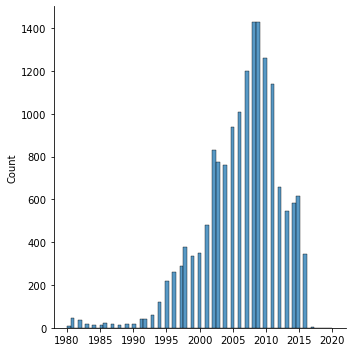

In [16]:
sns.displot(df['Year'])

In [17]:
df['Year'].median()

2007.0

In [31]:
len(df.filter(pl.col('Year') == 2007.0))

1202

In [22]:
df_new2 = df.with_columns(
    pl.col('Year').fill_null(pl.col('Year').median())
)

In [32]:
len(df_new2.filter(pl.col('Year') == 2007.0))

1473

In [24]:
df_new2.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,58,0,0,0,0,0


Yearの欠損値が0になり、2007.0の度数がその分（271）増えていることがわかる。